<a href="https://colab.research.google.com/github/Shiveshrane/Research_paper_implementations/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import os

In [2]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

--2025-02-12 16:29:52--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.207, 74.125.195.207, 172.253.117.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  72.4MB/s    in 6.9s    

2025-02-12 16:29:59 (71.4 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [3]:
import zipfile
zip_ref=zipfile.ZipFile('10_food_classes_all_data.zip')
zip_ref.extractall()
zip_ref.close()

In [4]:
train_dir='10_food_classes_all_data/train'
test_dir='10_food_classes_all_data/test'

In [47]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_gen=ImageDataGenerator(rescale=1/255.)
train_data=data_gen.flow_from_directory(train_dir, batch_size=32, target_size=(224,224), shuffle=True)
test_data=data_gen.flow_from_directory(test_dir, batch_size=32, target_size=(224,224), shuffle=True)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [50]:
class_names=os.listdir(train_dir)

In [48]:
train_data

In [51]:
class_names

['grilled_salmon',
 'hamburger',
 'ice_cream',
 'sushi',
 'steak',
 'chicken_curry',
 'chicken_wings',
 'fried_rice',
 'ramen',
 'pizza']

# Model

In [52]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *

In [53]:
class ResNetBlock(Layer):
  def __init__(self, out_channels, stride=1):
    super().__init__()
    first_padding='same'
    if stride!=1:
      first_padding='valid'
    self.conv_sequence=Sequential([
        Conv2D(out_channels, kernel_size=3, padding=first_padding, strides=stride),
        BatchNormalization(),
        ReLU(),
        Conv2D(out_channels, kernel_size=3, padding='same'),
        BatchNormalization(),
        ReLU()
    ])
  def call(self, inputs): #We apply the skip connections here.
    x=self.conv_sequence(inputs)
    if x.shape==inputs.shape:
      x+=inputs #Skip connection
    return x



In [54]:
layer=ResNetBlock(4)
print(layer)

<ResNetBlock name=res_net_block_49, built=False>


In [55]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPool2D, GlobalAveragePooling2D, Dense

In [56]:
class ResNet(Model):
  def __init__(self, num_classes=10):
    super(ResNet, self).__init__()

    self.conv_1=Sequential([Conv2D(filters=64, kernel_size=7, strides=2, padding='same', input_shape=(224,224,3)),
                            BatchNormalization(),
                            ReLU(),
                            MaxPool2D(pool_size=3, strides=2)
                            ])
    self.resnet_chain=Sequential([
        ResNetBlock(64),
        ResNetBlock(64),
        ResNetBlock(64)
    ]+
      [ResNetBlock(128, stride=2),ResNetBlock(128), ResNetBlock(128), ResNetBlock(128)]+
                              [ResNetBlock(256, stride=2),ResNetBlock(256), ResNetBlock(256), ResNetBlock(256), ResNetBlock(256), ResNetBlock(256)]+
                                 [ResNetBlock(512, stride=2),ResNetBlock(512), ResNetBlock(512)]
                                 )
    self.dense=Dense(num_classes, activation='softmax')
  def call(self, inputs):
    x=self.conv_1(inputs)
    x=self.resnet_chain(x)
    x= GlobalAveragePooling2D()(x)
    x=self.dense(x)
    return x


In [57]:
model=ResNet()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [36]:
print(model)

<ResNet name=res_net_1, built=False>


In [37]:
import os

In [16]:
def tensorboard_callback(dir_name, experiment_name):
  log_dir=os.path.join(dir_name, experiment_name)
  callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'Saving TensorBoard log files to: {log_dir}')
  return callback

In [17]:
def model_checkpoint(dir_name,experiment_name):
  checkpt_dir=os.path.join(dir_name, experiment_name)
  os.makedirs(checkpt_dir, exist_ok=True)
  print(f'Saving checkpoints to: {checkpt_dir}')
  checkpt_dir=os.path.join(checkpt_dir, 'model_checkpoint.weights.h5')
  checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpt_dir,
      save_weights_only=True,
      save_best_only=False,
      monitor='loss'
  )
  return checkpoint_callback

In [18]:
lr_scheduler=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.1,
                                                  patience=3,
                                                  min_lr=1e-6)

In [19]:
import os
import tensorflow as tf

def model_checkpoint(dir_name, experiment_name):
    checkpt_dir = os.path.join(dir_name, experiment_name)
    os.makedirs(checkpt_dir, exist_ok=True)
    print(f'Saving checkpoints to: {checkpt_dir}')
    checkpt_dir = os.path.join(checkpt_dir, 'model_checkpoint.weights.h5')
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpt_dir,
        save_weights_only=True,
        save_best_only=False,
        # The monitor should be a metric name (string), not a Dense object
        monitor='loss'
    )
    return checkpoint_callback

In [58]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.SGD(0.1, weight_decay=0.0001, momentum=0.9),
              metrics=['accuracy'])


In [39]:
print(model.summary())

Model: "res_net_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_35 (Sequential)           │ (None, 55, 55, 64)          │           9,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_52 (Sequential)           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,728 (38.00 KB)

 Trainable params: 9,600 (37.50 KB)

 Non-trainable params: 128 (512.00 B)

None


In [32]:
model.metrics_names

['loss', 'compile_metrics']

In [59]:
history=model.fit(train_data, epochs=10, validation_data=test_data, callbacks=[tensorboard_callback('logs', 'ResNet'), lr_scheduler, model_checkpoint('models', 'ResNet')])

Saving TensorBoard log files to: logs/ResNet
Saving checkpoints to: models/ResNet
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


235/235 ━━━━━━━━━━━━━━━━━━━━ 72s 231ms/step - accuracy: 0.1012 - loss: 2.3049 - val_accuracy: 0.1000 - val_loss: 2.3033 - learning_rate: 0.0100
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 44s 188ms/step - accuracy: 0.1045 - loss: 2.3026 - val_accuracy: 0.1000 - val_loss: 2.3011 - learning_rate: 0.0100
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 45s 189ms/step - accuracy: 0.1273 - loss: 2.2719 - val_accuracy: 0.1188 - val_loss: 2.2844 - learning_rate: 0.0100
Epoch 4/10
223/235 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.1380 - loss: 2.2617

KeyboardInterrupt: 

# Making the ResNet model using Functional API method

In [23]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPool2D, GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model

In [24]:
def ResNet():
  inputs=Input(shape=(224,224,3))
  x=Conv2D(filters=64, kernel_size=7, strides=2, padding='same')(inputs)
  x=BatchNormalization()(x)
  x=ReLU()(x)
  x=MaxPool2D(pool_size=3, strides=2)(x)
  x=ResNetBlock(64)(x)
  x=ResNetBlock(64)(x)
  x=ResNetBlock(64)(x)
  x=ResNetBlock(128, stride=2)(x)
  x=ResNetBlock(128)(x)
  x=ResNetBlock(128)(x)
  x=ResNetBlock(128)(x)
  x=ResNetBlock(256, stride=2)(x)
  x=ResNetBlock(256)(x)
  x=ResNetBlock(256)(x)
  x=ResNetBlock(256)(x)
  x=ResNetBlock(256)(x)
  x=ResNetBlock(256)(x)
  x=ResNetBlock(512, stride=2)(x)
  x=ResNetBlock(512)(x)
  x=ResNetBlock(512)(x)
  x=GlobalAveragePooling2D()(x)
  outputs=Dense(10, activation='softmax')(x)
  return Model(inputs, outputs)


In [25]:
model_2=ResNet()

In [60]:
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(0.001, weight_decay=0.0001, ema_momentum=0.9),
              metrics=['accuracy'])

In [27]:
model_2.summary()

Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 112, 112, 64)        │           9,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_35 (ReLU)                      │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 55, 55, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_net_block_17 (ResNetBlock)       │ (None, 55, 55, 64)          │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_net_block_18 (ResNetBlock)       │ (None, 55, 55, 64)          │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_net_block_19 (ResNetBlock)       │ (None, 55, 55, 64)          │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_net_block_20 (ResNetBlock)       │ (None, 27, 27, 128)         │         222,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_net_block_21 (ResNetBlock)       │ (None, 27, 27, 128)         │         296,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_net_block_22 (ResNetBlock)       │ (None, 27, 27, 128)         │         296,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_net_block_23 (ResNetBlock)       │ (None, 27, 27, 128)         │         296,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_net_block_24 (ResNetBlock)       │ (None, 13, 13, 256)         │         887,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_net_block_25 (ResNetBlock)       │ (None, 13, 13, 256)         │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_net_block_26 (ResNetBlock)       │ (None, 13, 13, 256)         │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_net_block_27 (ResNetBlock)       │ (None, 13, 13, 256)         │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_net_block_28 (ResNetBlock)       │ (None, 13, 13, 256)         │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_net_block_29 (ResNetBlock)       │ (None, 13, 13, 256)         │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_net_block_30 (ResNetBlock)       │ (None, 6, 6, 512)           │       3,544,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_net_block_31 (ResNetBlock)       │ (None, 6, 6, 512)           │       4,723,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_net_block_32 (ResNetBlock)       │ (None, 6, 6, 512)           │       4,723,7

 Total params: 21,138,826 (80.64 MB)

 Trainable params: 21,123,594 (80.58 MB)

 Non-trainable params: 15,232 (59.50 KB)

In [28]:
def scheduler(epoch, lr):
  if epoch%3==0:
    return lr*0.1
  else:
    return lr

In [29]:
lr_scheduler=tf.keras.callbacks.LearningRateScheduler(scheduler)

Since I am training the original ResNet on a relatively small dataset, as compared to ImageNet (1.2M images), the model is facing Overfitting.

In [61]:
history=model_2.fit(train_data, epochs=10, validation_data=test_data, callbacks=[tensorboard_callback('logs', 'ResNet_2'), model_checkpoint('models', 'ResNet_2')])

Saving TensorBoard log files to: logs/ResNet_2
Saving checkpoints to: models/ResNet_2
Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 100s 280ms/step - accuracy: 0.4091 - loss: 1.7611 - val_accuracy: 0.3388 - val_loss: 2.9079
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 59s 250ms/step - accuracy: 0.4463 - loss: 1.6426 - val_accuracy: 0.3716 - val_loss: 1.8929
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 57s 244ms/step - accuracy: 0.4797 - loss: 1.5672 - val_accuracy: 0.2684 - val_loss: 2.7533
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 57s 245ms/step - accuracy: 0.4973 - loss: 1.5125 - val_accuracy: 0.4324 - val_loss: 1.7703
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 52s 220ms/step - accuracy: 0.5076 - loss: 1.4528 - val_accuracy: 0.4004 - val_loss: 2.0172
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 58s 248ms/step - accuracy: 0.5407 - loss: 1.4067 - val_accuracy: 0.5000 - val_loss: 1.6205
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 58s 244ms/step - accuracy: 0.5540 - loss: 1.3371 - val_accuracy: 0.4164 - val_loss: 1.9

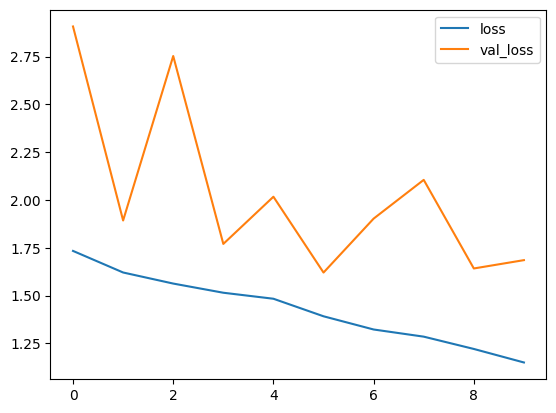

In [62]:
plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()



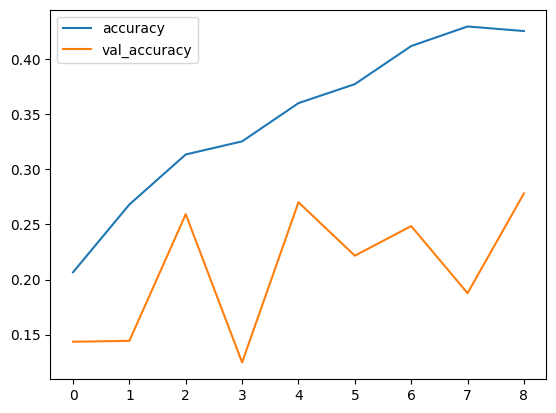

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()